In [1]:
#импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as mp
import numpy as np
import scipy.optimize as sp
from scipy.interpolate import spline
from sklearn.linear_model import LinearRegression

<h2>Задание 1</h2>
<h4>Определим необходимые функции:</h4>

In [2]:
#заданная модель
def model(X, b = 1):
    return [pow(x, 3) * b for x in X]

#квадратичная функция потерь
def lossFunction(X, Y, b):
    return np.sum(pow(np.abs(Y - model(X, b)), 2)) / len(X)

#вычисление параметра
def calculateBeta(X, Y):
    return Y / model(X)

#вычисление оптимального значения параметра
#Из перечисленных тут https://medium.freecodecamp.org/data-science-with-python-8-ways-to-do-linear-regression-and-measure-their-speed-b5577d75f8b способов,
#curve_fit оказался оптимальным
def calculateOptimalBeta(func, X, Y):
    return sp.curve_fit(func, X, Y)[0][0]

#собираем данные для отображения
def composeData(X, Y, betas, lossFunctionValues):
    data = pd.DataFrame()
    
    data['Height'] = X
    data['Weight'] = Y
    data['Beta'] = betas
    data['Loss Function'] = lossFunctionValues
    
    return data

<h4>Проведем вычисления:</h4>

In [3]:
heights = np.array([80, 120, 170, 180, 170])
weights = np.array([10, 20, 80, 80, 60])

betas = calculateBeta(heights, weights)
lossFunctionValues = [lossFunction(heights, weights, beta) for beta in betas]

optimalBeta = calculateOptimalBeta(model, heights, weights)
optimalBetaLossFunction = lossFunction(heights, weights, optimalBeta)

<h4>Отобразим полученные результаты:</h4>

In [4]:
data = composeData(heights, weights, betas, lossFunctionValues)

print(data)
print(f"Optimal Beta: {optimalBeta}\nLoss function value for optimal beta {optimalBetaLossFunction}")

   Height  Weight      Beta  Loss Function
0      80      10  0.000020     577.246246
1     120      20  0.000012     143.597447
2     170      80  0.000016     138.583693
3     180      80  0.000014      47.232750
4     170      60  0.000012      98.457856
Optimal Beta: 1.3959819485489763e-05
Loss function value for optimal beta 46.22758903935663


<h4>Построим графики:</h4>

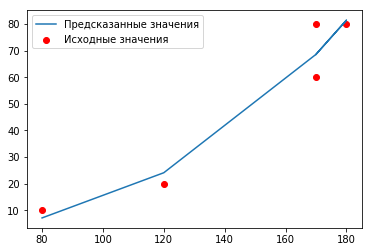

In [5]:
mp.scatter(heights, weights, color = 'red', label = 'Исходные значения')
mp.plot(heights, model(heights, optimalBeta), label = 'Предсказанные значения')
mp.legend(loc = 'upper left')
mp.show()

<h2>Задание 2</h2>
<h4>Импортируем данные и проводим их очистку</h4>

In [24]:
data = pd.read_csv("realtXY16.csv")
normData = data[(pd.to_numeric(data['Этажность'], 'coerce') >= data['Этаж']) & (data['Цена'] >= 10000) & (pd.to_numeric(data['Всего'], 'coerce') >= data['Раздельных'])].drop(columns = ['Nr', 'Прим', 'Квм', 'addres', 'coding adress', 'Адрес', 'Y', 'X', 'Раздельных']).dropna()

<h4>Подготовка данных:</h4>

In [25]:
normData['Этаж'] = normData['Этаж'].astype('int') 
normData['Всего'] = normData['Всего'].astype('int')
normData['Этажность'] = normData['Этажность'].astype('int') 
normData['Год'] = normData['Год'].astype('int')
normData['Жилая'] = normData['Жилая'].astype('int')
normData['Общая'] = normData['Общая'].astype('int')
normData['Кухня'] = normData['Кухня'].astype('int')

categoryVariables = pd.get_dummies(normData[['Район', 'Тип', 'Балкон']], prefix = ['Район', 'Тип', 'Балкон'])
normData = normData.drop(columns = ['Район', 'Тип', 'Балкон'])

normData = pd.merge(normData, categoryVariables, left_index = True, right_index = True)

<h4>Используем линейную регрессию</h4>

In [34]:
regression = LinearRegression()

x = normData.drop(columns = ['Цена'])
y = normData['Цена']

regression.fit(x, y)

normData['Предсказанная Цена'] = regression.predict(x)

undervaluedFlats = normData[normData['Цена'] / normData['Предсказанная Цена'] < 0.8]

<h4>Выводим полученные результаты</h4>

In [50]:
print(f'Коэфициенты регрессии:\n{regression.coef_}\n')
print('Недооцененные квартиры:')
undervaluedFlats[['Предсказанная Цена', 'Цена']]

Коэфициенты регрессии:
[-1.04818471e-07  7.03994092e-09 -9.04134738e-09  2.68394395e-08
 -3.75557925e-10  1.30268266e-08 -1.10246818e-10 -1.32298641e-07
  5.54361962e-08 -8.86989325e-09 -3.74453352e-08 -1.64053410e-09
  3.01854844e-08 -4.15095538e-08 -3.46637184e-08  1.70805995e-07
 -1.02993769e-07  6.97353693e-08  1.81403310e-07 -5.24972333e-08
 -3.10607821e-08 -2.14578643e-08 -7.63985786e-08  3.32695481e-08
 -2.20277150e-07  2.25567297e-07 -3.91293802e-07 -1.65468819e-07
 -3.57155055e-07 -2.54589490e-07 -4.75306029e-08 -4.17096040e-08
 -2.01585761e-07  4.24974415e-07 -2.37515767e-07  8.79567830e-08
 -1.78171459e-07 -1.33727978e-07 -2.04866254e-07 -1.30757468e-07
 -1.99773803e-07 -2.08808962e-07 -1.20730941e-07 -1.23143983e-07
 -1.42843641e-07 -9.21082257e-08  2.71356027e-06  1.00000000e+00]

Недооцененные квартиры:


,Предсказанная Цена,Цена
5,119971.964149,86900.0
7,83831.384912,59500.0
10,74942.381717,56000.0
14,86553.840642,65000.0
22,197765.799544,129000.0
28,105009.111947,66420.0
30,89208.119378,70000.0
34,102056.910720,77700.0
35,210549.581286,135500.0
52,67701.344838,52080.0
